# CS 121 Fall 2023 Lecture 3 : Computing all functions

In [1]:
%%html
<style>
.rise-enabled .cell .input_prompt {
    display: none;
}
</style>
<!--- <style>

# Utilities

In [2]:
import schemdraw
import schemdraw.logic as logic
import schemdraw.elements as elm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
COUNTER=0

class Bit:
    """A class representing a logical bit. 
       Keeps track of operations that are done to it"""
 
    def __init__(self, program):
        self.program = program if isinstance(program,tuple) else (program,)
        global COUNTER
        COUNTER += 1
  
    def op(self,oper, other = None):
        if other is None:
            return Bit((oper,self.program))
        return Bit((oper,self.program,other.program))
        
    def __and__(self,other): return self.op("∧", other)
    def __or__(self,other): return self.op("∨", other)
    def __invert__(self): return self.op("¬")
    
    def __repr__(self): return f"Bit({self.program})" 


In [115]:
def AND(a,b): 
    if isinstance(a,int) and isinstance(b,int):
        return int(bool(a) and bool(b))
    if isinstance(a,bool) and isinstance(b,bool):
        return a and b
    return a & b

def OR(a,b): 
    if isinstance(a,int) and isinstance(b,int):
        return int(bool(a) or bool(b))
    if isinstance(a,bool) or isinstance(b,bool):
        return a and b
    return a | b

def NOT(a): 
    if isinstance(a,Bit): return ~a
    if isinstance(a,int): return int(not a)
    return not a

def NAND(a,b):
    if isinstance(a,Bit) and isinstance(b,Bit):
        return a.op("N",b)
    return NOT(AND(a,b))

In [116]:
a = Bit("a")
b = Bit("b")
c = a & b
print(a)
print(b)
print(c)

Bit(('a',))
Bit(('b',))
Bit(('∧', ('a',), ('b',)))


In [117]:
def bits(n):
    return [Bit(f"X[{i}]") for i in range(n)]

In [118]:
def p2f(P):
  """Recursive function to transform a program of a Bit into a formula"""
  if len(P)==1:
    return P[0]
  if len(P)==2:
    return P[0] + p2f(P[1])
  if len(P)==3:
    return f"({p2f(P[1])} {P[0]} {p2f(P[2])})"
  return f"{P[0]}("+",".join([p2f(P[i]) for i in range(1,len(P))])+")"



In [119]:
counter = 0
def AON_(P):
    """Recursive function to transform a program of a bit into an AON straightline program"""
    def uid():
        global counter
        counter +=1
        return f"z_{counter}"
    funcs = {"∧": "AND", "∨": "OR", "¬": "NOT", "N":"NAND" }
    if len(P)==1:
        return "",P[0]
    op = funcs[P[0]]  
    if len(P)==2:
        prog, out_ = AON_(P[1])
        out = uid() 
        return prog+f"{out} = {op}({out_})\n", out
    if len(P)==3:
        prog1,out1 = AON_(P[1])
        prog2,out2 = AON_(P[2])
        out = uid()
        return prog1+prog2+f"{out} = {op}({out1},{out2})\n", out

In [120]:
def AON(f, n=None):
    """Take either a function or a bit and return the AON program"""
    global counter
    counter = 0
    if isinstance(f,Bit):
        P = f.program
    else:
        if n is None:
            n = len(signature(f).parameters)
        P = f(*bits(n)).program
    prog, out = AON_(P)
    return prog.replace(out,"Y[0]")

In [121]:
def formula(f):
    """Take either a function or a bit and return the AON program"""
    if isinstance(f,Bit):
        return Math(p2f(f.program))
    n = len(signature(f).parameters)
    F = p2f(f(*bits(n)).program)
    return Math(F)

In [122]:
def circuit_(P, d : schemdraw.Drawing , dx=0, dy=0, drawn = {}):
  """Recursive function to draw a circuit. Gets the Bit bit and outputs the circuit used to compute it"""
  if P in drawn:
    return drawn[P]
  maxx = dx
  maxy = dy
  outs = []
  gates = { "∧" : logic.And, "∨" : logic.Or, "¬": logic.Not, "N": logic.Nand } 
  for c in P[1:]:
    dx_ , dy_ , out = circuit_(c,d,dx,dy ,drawn)
    outs.append(out)
    maxx = max(dx_,maxx)
    maxy = max(dy_,maxy)
    dy = dy_ + 1
  maxx += 2
  x,y = maxx,maxy
  gate = gates[P[0]] if P[0] in gates else logic.Dot
  g = gate(at = (x,y))
  if isinstance(g, logic.Dot):
    g.label(f"{P[0]}")
  d += g
  for i,out in enumerate(outs):
    loc = getattr(g,f"in{i+1}") 
    d += logic.Wire().at(out).to(loc)  
  drawn[P] =  x,y, g.out if hasattr(g,"out") else (x,y)
  return drawn[P]

def draw_circ(*Ys):
  drawn = {}
  dx,dy = 0,0
  with schemdraw.Drawing() as d:
    d.config(unit=0.5)
    for i,y in enumerate(Ys):
      label= f"$Y[{i}]$"
      x,dy_, out = circuit_(y.program,d,dx,dy, drawn)
      d += logic.Dot().at(out).label(label)
      dy = dy_+2


In [123]:
def circuit(f,n=None):
    """Take a function or a bit and output circuit"""
    if isinstance(f,Bit):
        res = f
    else:
        if n is None:
            n = len(signature(f).parameters)
        res = f(*bits(n))
    return draw_circ(*res) if isinstance(res,(tuple,list)) else draw_circ(res)

In [124]:
def circ_size(f,n=None):
    if n is None:
        n = len(signature(f).parameters)
    global COUNTER
    COUNTER = 0
    res = f(*bits(n))
    return COUNTER-n    
    

In [125]:
import re
def parse(P):
    """Take an AON program and split each line into components"""
    result  = []
    for line in P.split('\n'):
        split = re.split("=|\(|\)|,| ",line) 
        split = [x for x in split if x != ""]
        if split:
            result.append(split)
    return result
 

In [126]:
def evalp(tuples,x, debug=True):
    """Evaluate a parsed program on an input"""
    variables = { f"X[{i}]":x[i] for i in range(len(x)) }
    for rhs,op,*oper in tuples:
        if debug: print(f"Evaluating {rhs} = {op}({','.join(oper)}):\t variables = {variables}")
        oper = [variables[o] for o in oper]
        variables[rhs] = globals()[op](*oper)
    return variables["Y[0]"]

In [127]:
def EVAL(P,x, debug=True): 
    """Evaluate an AON-CIRC program on an input x"""
    return evalp(parse(P),x, debug)

In [128]:
def nparams(P): 
    """Returns number of parameters of an AON-CIRC program P"""
    for i in range(len(P)+1):
        if f'X[{i}]' not in P: return i
def FUNC(P):
    """Returns the function that AON-CIRC program P computes"""
    # hack to get signature for small # of params
    n = nparams(P)
    if n == 1:
        def prog(a): return EVAL(P,[a],debug=False)
    elif n ==2:
        def prog(a,b): return EVAL(P,[a,b],debug=False)
    elif n ==3:
        def prog(a,b,c): return EVAL(P,[a,b,c],debug=False)
    else:
        def prog(*x): return EVAL(P,x,debug=False)
    return prog

In [129]:
import itertools
from IPython.display import Markdown, display, Math
from inspect import signature

def table(f,n=None):
  """Generate truth table of a function"""
  if n is None:
    n = len(signature(f).parameters)
  m = max(n+2,len(f.__name__)+4)
  res = "x".ljust(m) + " | " + f"{f.__name__}(x)".ljust(m) 
  res += "\n" + "-"*m+"-|-"+ "-"*m 
  
  for x in itertools.product([0,1],repeat=n):
    s = "".join([str(c) for c in x])
    #y = f(*[bool(i) for i in x])
    y = f(*x)
    #if isinstance(y,(list,tuple)):
    #    y = [int(bool(i)) for i in y]
    #else:
    #    y = int(bool(y))
        
    res += "\n"+ s.ljust(m) + " | " + str(y).ljust(m)
  res +="\n"
  return Markdown(res)

# Lecture

__Q:__ Write a circuit (AND/OR/NOT or NAND) that computes $IF:\{0,1\}^3\rightarrow \{0,1\}$ such that 
$$IF(a,b,c) = \begin{cases}b & a=1 \\ c & a=0 \end{cases}$$

In [130]:
def IF(cond,a,b):
    notcond = NAND(cond,cond)
    temp = NAND(b,notcond)
    temp1 = NAND(a,cond)
    return NAND(temp,temp1)

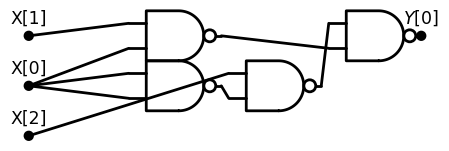

In [131]:
circuit(IF)

In [132]:
table(IF)

x      | IF(x) 
-------|-------
000    | 0     
001    | 1     
010    | 0     
011    | 1     
100    | 0     
101    | 0     
110    | 1     
111    | 1     


__Q:__ Show that there is a Boolean circuit that computes the function 
$$F(a,b,c) = \begin{cases}b \wedge c & a=1 \\ b \vee c & a=0 \end{cases}$$

In [133]:
def F(a,b,c): 
    d = AND(b,c)
    e = OR(b,c)
    return IF(a,d,e)

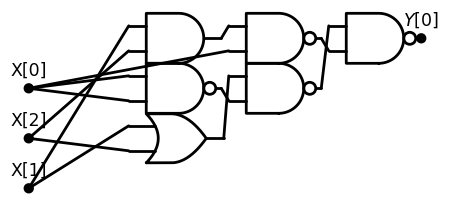

In [134]:
circuit(F)

In [135]:
table(F)

x     | F(x) 
------|------
000   | 0    
001   | 1    
010   | 1    
011   | 1    
100   | 0    
101   | 0    
110   | 0    
111   | 1    


In [139]:
def XOR(a,b): return IF(a,NOT(b),b)
table(XOR)

x       | XOR(x) 
--------|--------
00      | 0      
01      | 1      
10      | 1      
11      | 0      


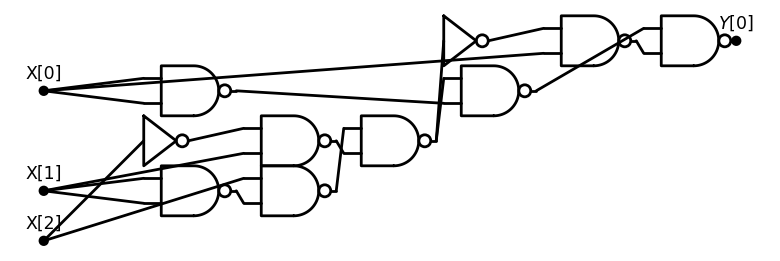

In [140]:
def XOR3(a,b,c): return XOR(a,XOR(b,c))
circuit(XOR3)

In [141]:
def zero(a):
    return AND(a,NOT(a))
table(zero)

x        | zero(x) 
---------|---------
0        | 0       
1        | 0       


In [143]:
def one(a):
    return OR(a,NOT(a))
table(one)

x       | one(x) 
--------|--------
0       | 1      
1       | 1      


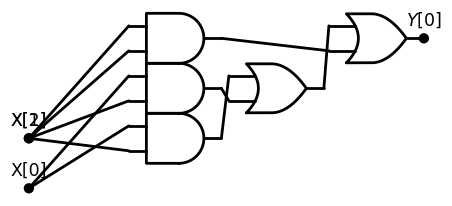

In [144]:
def MAJ(a,b,c): return (a&b) | (a&c) | (b&c)
circuit(MAJ)

__Q:__ Write a circuit for the function $INC:\{0,1\}^3 \rightarrow \{0,1\}^4$ such that $INC(x_0,x_1,x_2)$ is the (LSB first) binary representation of $x+1$ (for $x = x_0 +2x_1 + 4x_2$).  (Follow-up: generalize for all $n$)

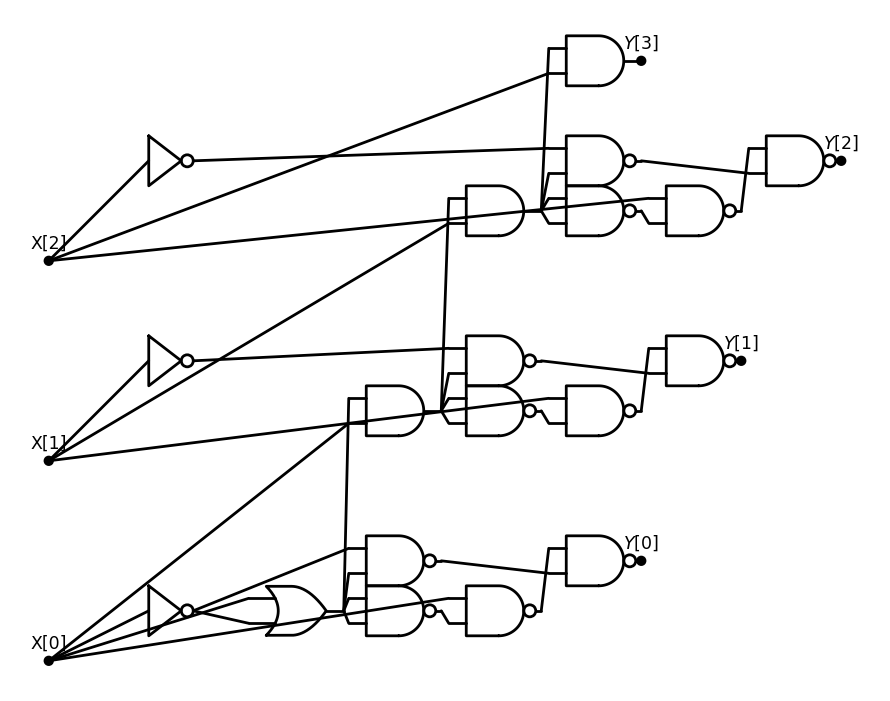

In [149]:
N = 3
def INC(*X,n=N):
    Result = [0]*(n+1)
    Carry  = one(X[0])
    for i in range(n):
        Result[i] = XOR(Carry,X[i])
        Carry = Carry & X[i]
    Result[n] = Carry
    return Result
circuit(INC,n=N)

In [146]:
print(P := AON(lambda *X: INC(*X)[0],N))

z_1 = NOT(X[0])
z_2 = OR(X[0],z_1)
z_3 = NOT(X[0])
z_4 = OR(X[0],z_3)
z_5 = NAND(z_2,z_4)
z_6 = NAND(X[0],z_5)
z_7 = NOT(X[0])
z_8 = NOT(X[0])
z_9 = OR(X[0],z_8)
z_10 = NAND(z_7,z_9)
Y[0] = NAND(z_6,z_10)



In [147]:
EVAL(P,[1,1])

Evaluating z_1 = NOT(X[0]):	 variables = {'X[0]': True, 'X[1]': True}
Evaluating z_2 = OR(X[0],z_1):	 variables = {'X[0]': True, 'X[1]': True, 'z_1': 0}
Evaluating z_3 = NOT(X[0]):	 variables = {'X[0]': True, 'X[1]': True, 'z_1': 0, 'z_2': 1}
Evaluating z_4 = OR(X[0],z_3):	 variables = {'X[0]': True, 'X[1]': True, 'z_1': 0, 'z_2': 1, 'z_3': 0}
Evaluating z_5 = NAND(z_2,z_4):	 variables = {'X[0]': True, 'X[1]': True, 'z_1': 0, 'z_2': 1, 'z_3': 0, 'z_4': 1}
Evaluating z_6 = NAND(X[0],z_5):	 variables = {'X[0]': True, 'X[1]': True, 'z_1': 0, 'z_2': 1, 'z_3': 0, 'z_4': 1, 'z_5': 0}
Evaluating z_7 = NOT(X[0]):	 variables = {'X[0]': True, 'X[1]': True, 'z_1': 0, 'z_2': 1, 'z_3': 0, 'z_4': 1, 'z_5': 0, 'z_6': 1}
Evaluating z_8 = NOT(X[0]):	 variables = {'X[0]': True, 'X[1]': True, 'z_1': 0, 'z_2': 1, 'z_3': 0, 'z_4': 1, 'z_5': 0, 'z_6': 1, 'z_7': 0}
Evaluating z_9 = OR(X[0],z_8):	 variables = {'X[0]': True, 'X[1]': True, 'z_1': 0, 'z_2': 1, 'z_3': 0, 'z_4': 1, 'z_5': 0, 'z_6': 1, 'z_7': 0, 'z

0

In [150]:
table(INC,N)

x       | INC(x) 
--------|--------
000     | [1, 0, 0, 0]
001     | [1, 0, 1, 0]
010     | [1, 1, 0, 0]
011     | [1, 1, 1, 0]
100     | [0, 1, 0, 0]
101     | [0, 1, 1, 0]
110     | [0, 0, 1, 0]
111     | [0, 0, 0, 1]


In [156]:
def n2b(x,n=N): 
    L= [int(i) for i in bin(x)[2:]][::-1]
    return L + [0]*(n-len(L))

def b2n(L): return sum([x*2**i for i,x in enumerate(L)])

b2n( INC(*n2b(5)))


6

__Q__ Show that there is a Boolean circuit that computes $ADD_2:\{0,1\}^4 \rightarrow \{0,1\}^3$ such that $ADD_2(a,b,c,d)$ is the binary representation of $a +2b+c+2d$.

_Extra:_ Show a circuit for $ADD_n:\{0,1\}^{2n} \rightarrow \{0,1\}^{2n}$ such that 
$$ADD_n(x_0,\ldots,x_{n-1},y_0,\ldots,y_{n-1}) = \sum_{i=0}^{n-1}2^i(x_i+y_i)$$

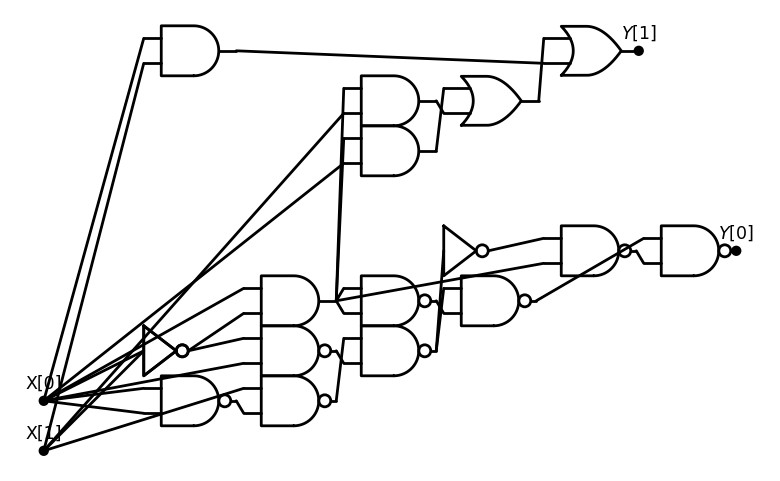

In [30]:
N = 1
def ADD(*X,n=N):
    A=X[:n]
    B=X[n:]
    Result = [0]*(n+1)
    Carry  = [0]*(n+1)
    Carry[0] = zero(A[0])
    for i in range(n):
        Result[i] = XOR3(Carry[i],A[i],B[i])
        Carry[i+1] = MAJ(Carry[i],A[i],B[i])
    Result[n] = Carry[n]
    return Result
circuit(ADD,n=2*N)

In [31]:
table(ADD, n=2*N)

x       | ADD(x) 
--------|--------
00      | [0, 0] 
01      | [1, 0] 
10      | [1, 0] 
11      | [0, 1] 


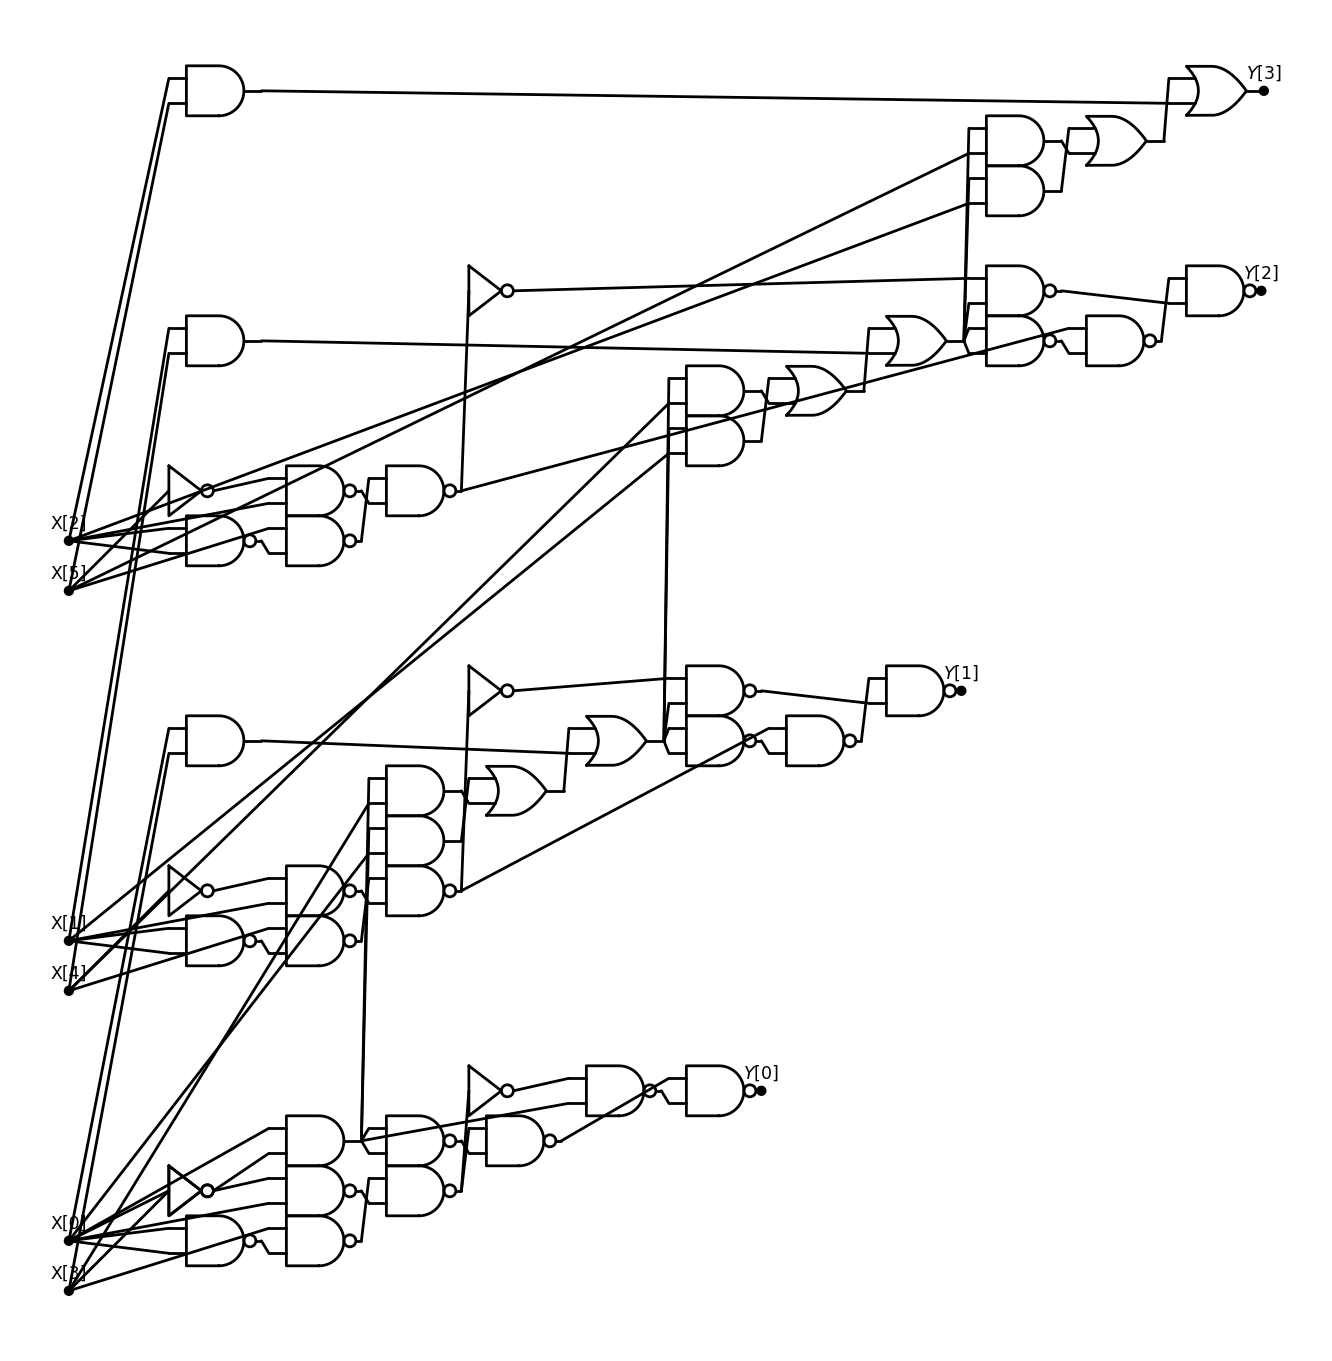

In [32]:
N = 3
def ADD(*X,n=N):
    A=X[:n]
    B=X[n:]
    Result = [0]*(n+1)
    Carry  = [0]*(n+1)
    Carry[0] = zero(A[0])
    for i in range(n):
        Result[i] = XOR3(Carry[i],A[i],B[i])
        Carry[i+1] = MAJ(Carry[i],A[i],B[i])
    Result[n] = Carry[n]
    return Result
circuit(ADD,n=2*N)

In [33]:
table(ADD, n=2*N)

x        | ADD(x)  
---------|---------
000000   | [0, 0, 0, 0]
000001   | [0, 0, 1, 0]
000010   | [0, 1, 0, 0]
000011   | [0, 1, 1, 0]
000100   | [1, 0, 0, 0]
000101   | [1, 0, 1, 0]
000110   | [1, 1, 0, 0]
000111   | [1, 1, 1, 0]
001000   | [0, 0, 1, 0]
001001   | [0, 0, 0, 1]
001010   | [0, 1, 1, 0]
001011   | [0, 1, 0, 1]
001100   | [1, 0, 1, 0]
001101   | [1, 0, 0, 1]
001110   | [1, 1, 1, 0]
001111   | [1, 1, 0, 1]
010000   | [0, 1, 0, 0]
010001   | [0, 1, 1, 0]
010010   | [0, 0, 1, 0]
010011   | [0, 0, 0, 1]
010100   | [1, 1, 0, 0]
010101   | [1, 1, 1, 0]
010110   | [1, 0, 1, 0]
010111   | [1, 0, 0, 1]
011000   | [0, 1, 1, 0]
011001   | [0, 1, 0, 1]
011010   | [0, 0, 0, 1]
011011   | [0, 0, 1, 1]
011100   | [1, 1, 1, 0]
011101   | [1, 1, 0, 1]
011110   | [1, 0, 0, 1]
011111   | [1, 0, 1, 1]
100000   | [1, 0, 0, 0]
100001   | [1, 0, 1, 0]
100010   | [1, 1, 0, 0]
100011   | [1, 1, 1, 0]
100100   | [0, 1, 0, 0]
100101   | [0, 1, 1, 0]
100110   | [0, 0, 1, 0]
100111   | [0, 0, 0, 1]
101000   | [1, 0, 1, 0]
101001   | [1, 0, 0, 1]
101010   | [1, 1, 1, 0]
101011   | [1, 1, 0, 1]
101100   | [0, 1, 1, 0]
101101   | [0, 1, 0, 1]
101110   | [0, 0, 0, 1]
101111   | [0, 0, 1, 1]
110000   | [1, 1, 0, 0]
110001   | [1, 1, 1, 0]
110010   | [1, 0, 1, 0]
110011   | [1, 0, 0, 1]
110100   | [0, 0, 1, 0]
110101   | [0, 0, 0, 1]
110110   | [0, 1, 1, 0]
110111   | [0, 1, 0, 1]
111000   | [1, 1, 1, 0]
111001   | [1, 1, 0, 1]
111010   | [1, 0, 0, 1]
111011   | [1, 0, 1, 1]
111100   | [0, 0, 0, 1]
111101   | [0, 0, 1, 1]
111110   | [0, 1, 0, 1]
111111   | [0, 1, 1, 1]


In [157]:
def add(x,y):
    return b2n(ADD(*(n2b(x,N)+n2b(y,N))))
add(2,3)

5

In [158]:
for x in range(0,2**N):
    for y in range(0,2**N):
        print("X" if add(x,y)!=x+y else "✓",end="")

✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓

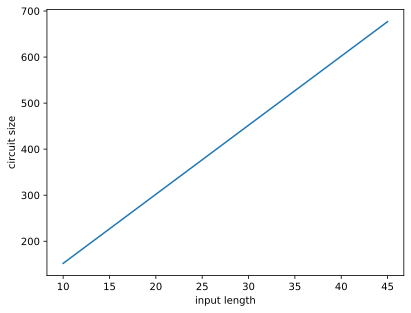

In [159]:
X = list(range(10,50,5))
Y = [circ_size(lambda *X:ADD(*X,n=n),2*n) for n in X]
import matplotlib.pyplot as plt
plt.plot(X,Y)
plt.ylabel('circuit size')
plt.xlabel('input length')
plt.show()